# Applicating CPS to MOB dataset

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = False
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/stereo-seq'
args.radius=50
args.clusters=6
args.hvgs=2000
args.er_w=1.0
args.sigma=3
args.freq=32
CPS.set_random_seed(args.seed)
args.k_list = [0,1,2,3,4,5,6,7]
# [0,1,2,3,4,5,6,7][0,1,2,3,5,8,13,21][0,1,2,4,6,8,10,12][0,1,2,4,8,16,32,64]
args

Namespace(batch_size=1024, clusters=6, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/stereo-seq', decoder_latent=[256, 512, 1024], distill=1.0, dropout=0.2, embedd_dim=512, er_w=10, flow='source_to_target', freq=32, gpu=0, hvgs=2000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=6, n_spot=0, num_heads=4, prep_scale=False, radius=50, seed=2025, self_loops=True, sigma=3, weight_decay=0.0001)

In [4]:
# from scipy.sparse import csr_matrix
# counts_file = os.path.join(args.dataset_path, 'RNA_counts.tsv')
# coor_file = os.path.join(args.dataset_path, 'position.tsv')
# counts = pd.read_csv(counts_file, sep='\t', index_col=0)
# coor_df = pd.read_csv(coor_file, sep='\t')
# counts.columns = ['Spot_'+str(x) for x in counts.columns]
# coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
# coor_df = coor_df.loc[:, ['x','y']]
# adata = sc.AnnData(counts.T)
# adata.X = csr_matrix(adata.X)
# adata.var_names_make_unique()
# coor_df = coor_df.loc[adata.obs_names, ['y', 'x']]
# adata.obsm["spatial"] = coor_df.to_numpy()
# sc.pp.calculate_qc_metrics(adata, inplace=True)
# used_barcode = pd.read_csv(os.path.join(args.dataset_path, 'used_barcodes.txt'), sep='\t', header=None)
# used_barcode = used_barcode[0]
# adata = adata[used_barcode,]
# sc.pp.filter_genes(adata, min_cells=50)
# adata.write(args.dataset_path + '/MOB_raw.h5ad')
# adata

preprocessed adata

In [5]:
# adata.layers["counts"] = adata.X.copy()
# sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
# adata_hvg = adata[:, adata.var['highly_variable']].copy()
# sc.pp.normalize_total(adata_hvg, target_sum=1e4)
# sc.pp.log1p(adata_hvg)
# sc.pp.scale(adata_hvg, zero_center=True, max_value=10)

# counts_layer = adata_hvg.layers['counts']
# adata_hvg.obsm['hvg_features'] = adata_hvg.X
# adata_hvg.obsm['hvg_counts'] = counts_layer.toarray()
# adata_hvg.write(args.dataset_path + '/MOB_hvg.h5ad')

In [6]:
adata_hvg = sc.read(args.dataset_path + '/MOB_hvg.h5ad')

In [7]:
spatial_edge = CPS.SpatialGraphBuilder(args)
pyg_data = spatial_edge.build_single_graph(adata_hvg, method='rknn')
print(pyg_data.num_nodes, pyg_data.num_genes, pyg_data.edge_index.shape)

19109 2000 torch.Size([2, 138309])


In [8]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(pyg_data)

  0%|          | 0/1000 [00:00<?, ?it/s]

10.39588737487793 2.0793094635009766

Epoch   0: Train[Total:11.4533, T:10.5441, S:0.1427, D:0.7665]
10.395271301269531 2.0792479515075684
10.394065856933594 2.079127311706543
10.3916597366333 2.0788867473602295
10.386493682861328 2.0783700942993164
10.375456809997559 2.0772664546966553
10.354488372802734 2.075169563293457
10.313959121704102 2.0711166858673096
10.24284553527832 2.0640053749084473
10.13211441040039 2.0529322624206543
9.960700988769531 2.0357909202575684

Epoch  10: Train[Total:10.5932, T:10.0748, S:0.1145, D:0.4038]
9.709835052490234 2.010704278945923
9.37327766418457 1.9770485162734985
8.902904510498047 1.93001127243042
8.320920944213867 1.8718128204345703
7.605295181274414 1.8002502918243408
6.752666473388672 1.7149873971939087
5.767516136169434 1.6164723634719849
4.672238826751709 1.5069446563720703
3.525981903076172 1.3923189640045166
2.3032844066619873 1.2700492143630981

Epoch  20: Train[Total:2.9714, T:2.4161, S:0.1131, D:0.4423]
1.1418092250823975 1.153901696205

0.0 0.3912901282310486


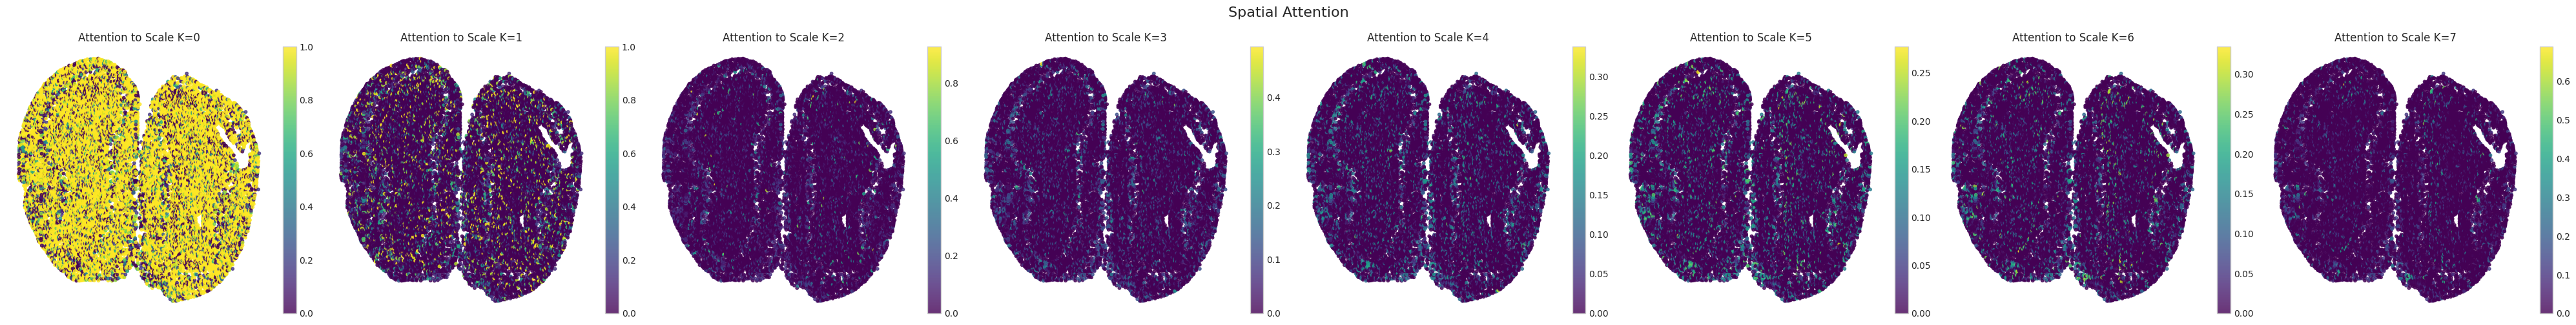

In [9]:
z_s, latent, attn = cps_model.interpret_attn_scores(pyg_data, verbose=True)
adata_hvg.obsm['z_s'] = z_s
adata_hvg.obsm['z_t'] = latent
adata_hvg.obsm['attns'] = attn
adata_hvg.obsm['attn'] = attn.reshape(adata_hvg.n_obs, 32)

In [10]:
x = pyg_data.x
pos = pyg_data.pos

edge_index = pyg_data.edge_index

cps_model.model.to('cpu')
z_teacher, attn, er_loss = cps_model.model.teacher(x, edge_index)

0.0 0.3912903368473053


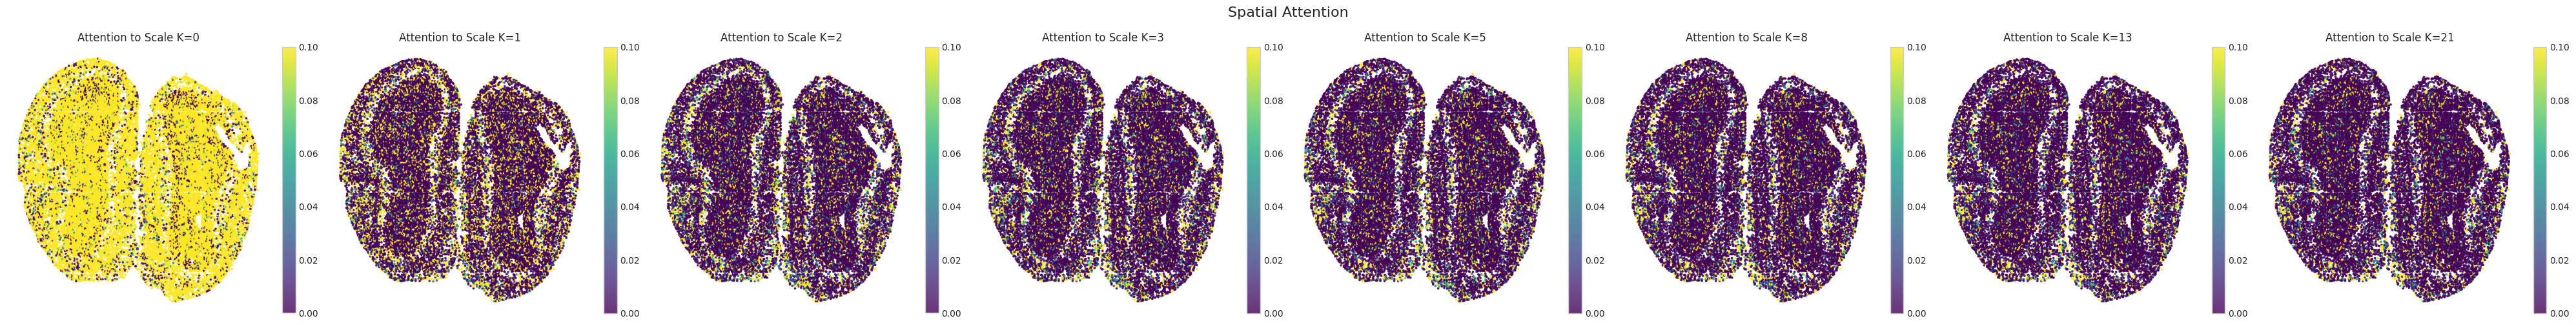

In [12]:
attn_avg_heads = attn.mean(axis=-1).cpu().detach().numpy()
pos = pyg_data.pos.cpu().numpy()
pos_cpu = pos

n_scales = len([0,1,2,3,5,8,13,21])
fig, axes = plt.subplots(1, n_scales, figsize=(5 * n_scales, 5))
if n_scales == 1:
    axes = [axes]

for i, k in enumerate([0,1,2,3,5,8,13,21]):
    ax = axes[i]
    sc = ax.scatter(pos_cpu[:, 0], pos_cpu[:, 1],
                    c=attn_avg_heads[:, i],vmax=0.1,
                    cmap='viridis', s=3, alpha=0.8)
    ax.set_title(f"Attention to Scale K={k}")
    ax.axis('off')
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    
plt.suptitle("Spatial Attention", fontsize=16)
plt.tight_layout()